# Labeled LDA - Splatalogue -ALMA Spectral Line Classification

En este notebook se presenta una propuesta para realizar clasificación de líneas espectrales sobre cubos de datos de observaciones del Atacama Large Milimeter/Submilimeter Array (ALMA), utilizando un modelo de mezclas conocido como Labeled Latent Dirichlet Allocation (LDA). Los modelos se entrenan con datos de una base de datos de transiciones moleculares llamada Splatalogue, para luego realizar inferencia sobre datos de observaciones.

## Creación de un modelo

Se descargan los datos de transiciones de un filtro seleccionado desde Splatalogue (http://www.cv.nrao.edu/php/splat/index.php). Por ejemplo, se selecciona el filtro __Top20__ y se exportan los datos de sus transiciones en formato csv (asuma que los datos se guardan en un archivo __splatalogue_top20.csv__), luego se generan archivos .raw por cada esquema de _channeling_ a evaluar. A continuación se generan los archivos para _channeling_ 0, 2 y 5.

In [44]:
!python ./catalogo_splat/splat2raw.py ./catalogo_splat/splatalogue_top20.csv 0 > ./catalogo_raw/top20_tr.raw
!python ./catalogo_splat/splat2raw.py ./catalogo_splat/splatalogue_top20.csv 2 > ./catalogo_raw/top20_2.raw
!python ./catalogo_splat/splat2raw.py ./catalogo_splat/splatalogue_top20.csv 5 > ./catalogo_raw/top20_full.raw

Para entrenar los modelos L-LDA se utiliza una implementación en JAVA provista por Myle Ott, JGibbLabeledLDA (https://github.com/myleott/JGibbLabeledLDA). Es necesario obtener la representación necesaria según se indica en la documentación de JGibbLabeledLDA:

[label_1,1 label_1,2 ... label_1,l_1] document_1<br>
[label_2,1 label_2,2 ... label_2,l_2] document_2<br>
...<br>
[label_m,1 label_m,2 ... label_m,l_m] document_m<br>

Por cada especie molecular de cada corpus se reunen las transiciones correspondientes, luego se generan las palabras en función de la energía de la transición. Por cada especie se genera un documento y un tópico (etiqueta) asociado. Los pasos siguientes demoran un poco, por favor sea paciente.

In [8]:
#!g++ -std=c++0x -Icodes_mmmss/boost_1_67_0/ -o ./codes_mmmss/splat2data.o ./codes_mmmss/splat2data.cpp

In [46]:
!cp ./catalogo_raw/top20_tr.raw top20_tr.raw
!./codes_mmmss/splat2data.o top20_tr.raw > top20_tr.dat
!rm top20_tr.raw
!mv top20_tr.dat ./llda_train_input/top20_tr.dat
!mv top20_tr_labelmap.sub ./llda_train_input/top20_tr_labelmap.sub

!cp ./catalogo_raw/top20_2.raw top20_2.raw
!./codes_mmmss/splat2data.o top20_2.raw > top20_2.dat
!rm top20_2.raw
!mv top20_2.dat ./llda_train_input/top20_2.dat
!mv top20_2_labelmap.sub ./llda_train_input/top20_2_labelmap.sub

!cp ./catalogo_raw/top20_full.raw top20_full.raw
!./codes_mmmss/splat2data.o top20_full.raw > top20_full.dat
!rm top20_full.raw
!mv top20_full.dat ./llda_train_input/top20_full.dat
!mv top20_full_labelmap.sub ./llda_train_input/top20_full_labelmap.sub

Una vez se obtiene el input de L-LDA para cada esquema de channeling se realiza un pre procesamiento de los datos en donde se eliminan aquellos documentos (filas) que no posean información.

In [52]:
!python ./llda_train_input/get_blank.py ./llda_train_input/top20_tr.dat > blanks.tmp

topics2clean = []
with open("blanks.tmp") as f:
    for line in f:
        if len(line) > 1:
            topics2clean.append(int(line[1:-3]))
print("Topics to clean: " + str(topics2clean))

for topic in reversed(topics2clean):
    !python ./llda_train_input/fixer.py ./llda_train_input/top20_tr.dat ./llda_train_input/top20_tr_labelmap.sub $topic
    !python ./llda_train_input/fixer.py ./llda_train_input/top20_2.dat ./llda_train_input/top20_2_labelmap.sub $topic
    !python ./llda_train_input/fixer.py ./llda_train_input/top20_full.dat ./llda_train_input/top20_full_labelmap.sub $topic

Topics to clean: []


Se obtiene el mapa de características para ser usado posteriormente en la construcción de un documento a partir de un cubo de datos con formato FITS.

In [54]:
!python ./scripts/get_vocabulary.py ./llda_train_input/top20_tr.dat > ./llda_train_input/top20_tr_features.dat
!python ./scripts/get_vocabulary.py ./llda_train_input/top20_2.dat > ./llda_train_input/top20_2_features.dat
!python ./scripts/get_vocabulary.py ./llda_train_input/top20_full.dat > ./llda_train_input/top20_full_features.dat

!wc -w ./llda_train_input/top20_*_features.dat

 28232 ./llda_train_input/top20_2_features.dat
 31481 ./llda_train_input/top20_full_features.dat
  8742 ./llda_train_input/top20_tr_features.dat
 68455 total


Luego de realizar la limpieza se calculan los hiper parámetros $\alpha$ y $\beta$ para cada uno de los modelos. A continuación se presenta el detalle de los modelos evaluados:

<table>
<tr><th>Modelo</th><th>Tópicos (K)</th><th>Características (M)</th><th>$\alpha$</th><th>$\beta$</th></tr>
<tr><td>Top20 Ch(0)</td><td>10</td><td>8742</td><td>5.0</td><td>0.0011</td></tr>
<tr><td>Top20 Ch(2)</td><td>10</td><td>28232</td><td>5.0</td><td>0.0004</td></tr>
<tr><td>Top20 Ch(5)</td><td>10</td><td>31481</td><td>5.0</td><td>0.0003</td></tr>
</table>

Posteriormente se generan los modelos de mezclas L-LDA utilizando la implementación JGibbLabeledLDA:

In [56]:
!gzip -k ./llda_train_input/top20_tr.dat
!python train_auto.py ./llda_train_input/top20_tr.dat.gz 5.0 0.0011 10 500 model_top20_tr_500it
!rm ./llda_train_input/top20_tr.dat.gz

!gzip -k ./llda_train_input/top20_2.dat
!python train_auto.py ./llda_train_input/top20_2.dat.gz 5.0 0.0004 10 500 model_top20_2_500it
!rm ./llda_train_input/top20_2.dat.gz

!gzip -k ./llda_train_input/top20_full.dat
!python train_auto.py ./llda_train_input/top20_full.dat.gz 5.0 0.0003 10 500 model_top20_full_500it
!rm ./llda_train_input/top20_full.dat.gz

Trainning model model_top20_2_500it
Dataset loaded:
	M:10
	V:28232
Sampling 500 iterations!
Iteration                                                                                                                                                                                                                                                                                                                                                                                                               1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   

Los modelos quedan guardados en ./llda_models/

### Expansión de Términos

Para mejorar el poder de predicción del algoritmo L-LDA se realiza una expansión de términos tratando de simular la curva de una transición que se observa en observaciones astronómicas. Este fenómeno se produce por Doppler Broadening, el estado de excitación de las particulas de un objeto de observación genera Redshift y Blueshift para las líneas espectrales.

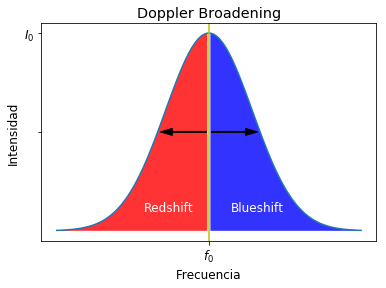

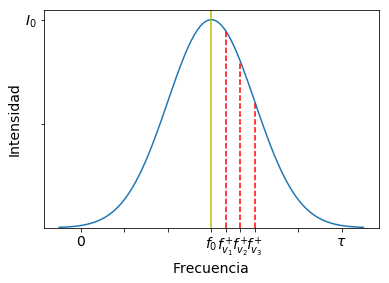

In [51]:
%run /home/sebastian/codigos/python/doppler_broadening.py
%run /home/sebastian/codigos/python/gaussian_plot.py

La expansión se realiza para el modelo de máxima resolución ($channeling = 5$). Se establece un soporte $\tau = 0.01000\,[GHz]$ y una expansión de $\chi = 3$ vecinos hacia cada lado.

In [57]:
!cp ./llda_train_input/top20_full.dat .
!python ./scripts/frequency_expander.py top20_full.dat 3 0.01000
!mv top20_full_expanded.dat ./llda_train_input/top20_full_expanded_01000_x3.dat
!rm top20_full.dat
!python ./scripts/get_vocabulary.py ./llda_train_input/top20_full_expanded_01000_x3.dat > ./llda_train_input/top20_full_expanded_01000_x3_features.dat

Reading Species 10/10
Execution Time: 104.62991404533386 seconds


Se entrena el nuevo modelo

In [59]:
!gzip -k llda_train_input/top20_full_expanded_01000_x3.dat
!python train_auto.py llda_train_input/top20_full_expanded_01000_x3.dat.gz 0.4 0.1 132 500 model_top20_full_expanded_01000_x3_500it
!rm llda_train_input/top20_full_expanded_01000_x3.dat.gz

Trainning model model_top20_full_expanded_01000_x3_500it
Dataset loaded:
	M:10
	V:220263
Sampling 500 iterations!
Iteration                                                                                                                                                                                                                                                                                                                                                                                                               1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2 

## Procesamiento del FITS

A continuación se realiza el procesamiento de los cubos de datos en formato FITS. La idea es representar los espectros de los cubos de datos como documentos, para esto se realiza un procesamiento de los FITS que los transforma a esta representación. Se ejemplifica el caso de un FITS con nombre __DMTau.CS_5-4.image.fits__

Parsing Fits: ../FITS/Orion.methanol.cbc.contsub.image.fits
sigma_thresshold: 1.5
Estimated number of clusters: 1

Freq/Energy Max: 229753394598.98422/38.3760285297

Redshift: 2.439746766554356e-05 Restfreq of spectral line: 229759000000.0


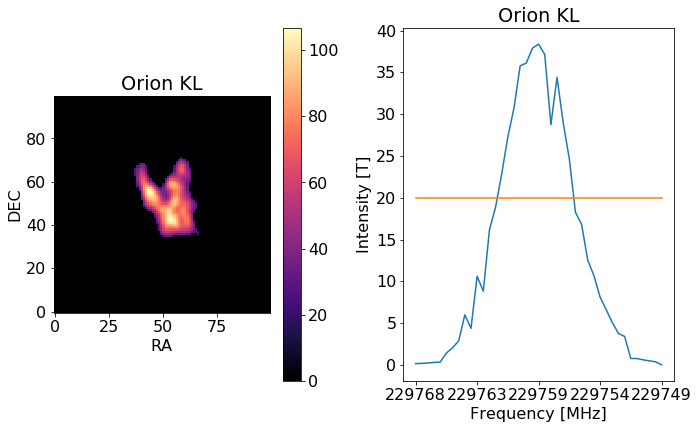

Generated File:
22975752 22975752 22975752 22975752 22975752 22975752 22975752 22975752 22975752 22975752 22975752 22975752 22975752 22975752 22975752 22975752 22975760 22975760 22975760 22975760 22975760 22975876 22975876 22975876 22975876 22975876 22975876 22975878 22975878 22975878 22975878 22975878 22975878 22975878 22975878 22975878 22975878 22975878 22975878 22976052 22976052 22976052 22976052 22976052 22976052 22976052 22976052 22976052 22976052 22976052 22976052 22976052 22976052 22976052 22976052 22976052 22976162 22976162 22976162 22976162 22976162 22976162 22976162 22976162 22976162 22976162

Parsing time: 0.7576196193695068 seconds


In [41]:
fits_name = "../FITS/DMTau.CS_5-4.image.fits"
fits_name = "../FITS/Orion.methanol.cbc.contsub.image.fits"
channeling = 5
%run ./scripts/llda_parser.py $fits_name $channeling ./llda_train_input/test_full_features.dat -p

## Evaluación del Algoritmo

Se realiza inferencia sobre el documento generado desde el procesamiento del cubo de datos. Se debe incorporar el índice de la etiqueta de la especie que se desea clasificar, en este caso para el cubo de datos __DMTau.CS_5-4.image.fits__ se desea encontrar __Carbon Monosulfide (CS)__. Para realizar la inferencia se utilizará el modelo __Top20__ en máxima resolución (full): $channeling = 5$

In [60]:
cat ./llda_train_input/top20_full_labelmap.sub

0 Carbon Monoxide
1 Hydrogen Cyanide
2 Formaldehyde
3 Sulfur dioxide
4 Methanol
5 Formylium
6 Ammonia
7 Carbon Monosulfide
8 Silicon Monoxide
9 Water


In [65]:
import os
os.chdir('/home/sebastian/memoria/llda_spectral_lines/')

fits_name = "../../FITS/DMTau.CS_5-4.image.fits"
model = "./llda_models/model_top20_full_expanded_01000_x3_500it/"
features = "./llda_train_input/top20_full_expanded_01000_x3_features.dat"
labelmap = "./llda_train_input/top20_full_labelmap.sub"
channeling = 5
species_no = 7

!python ./inference.py $model $features $labelmap $channeling $fits_name $species_no

Parsing Fits: ../../FITS/DMTau.CS_5-4.image.fits
sigma_thresshold: 2.5
Estimated number of clusters: 1

Freq/Energy Max: 244929904058.8581/1.13188068729

Redshift: 2.3079832426457423e-05 Restfreq of spectral line: 244935557000.0
Generated File:
24493222 24493389 24493389 24493556 24493556 24493556 24493556 24493556 24493556 24493556 24493722 24493722 24493722 24493722 24493722 24493722

Parsing time: 0.9779708385467529 seconds
Used model: model_top20_full_expanded_01000_x3_500it
Dataset loaded:
	M:1
	V:4
Model loaded:
	alpha:0.4
	beta:0.1
	K:132
	M:10
	V:220263
Dataset loaded:
	M:1
	V:4
Sampling 200 iterations for inference!
Iteration                                                                                                                                                                                                                                                                                                                                                                      

## Referencias

<ol>
<li>M. Mendoza, A. Barrientos, M. Solar, and M. Araya.  Mixed membership models for
source separation of spectral lines.  In
8th International Conference of Pattern Recog-
nition Systems (ICPRS 2017)
, pages 1–6, July 2017.</li>
</ol>